<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE6-FaultPredictionAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

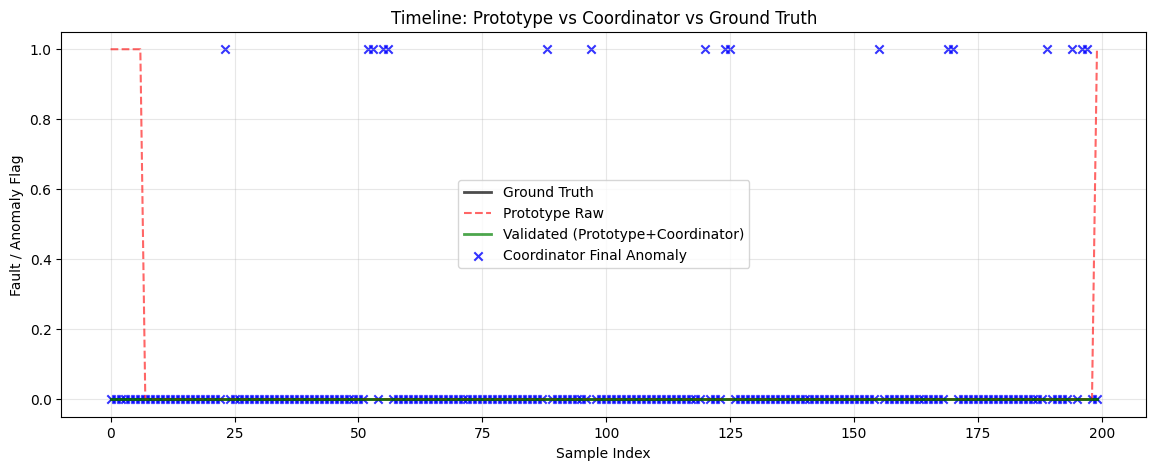


=== False Positive Suppression Analysis (Prototype) ===
False Positives (Raw Prototype): 454
False Positives (Validated): 92
False Negatives (Raw Prototype): 0
False Negatives (Validated): 4
Suppression Rate: 79.74%


In [42]:


# ============================================================
# Fault Classification Pipeline
# ============================================================

############PASTE ADAPTIVE WINDOW HERE - so everything is in one file - later, we can import as a package#####################


# ====== AdaptiveWindowAgent ======
# =====================================================
# AdaptiveWindowAgent (improved version)
# =====================================================
import numpy as np
import pandas as pd
import pickle, os, logging, datetime as dt
from collections import deque
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras

logger = logging.getLogger(__name__)

class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with VAR
    - Monitors anomalies & drift with adaptive thresholds
    - Outputs severity scores + suppresses redundant events
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
        self.checkpoint_path = checkpoint_path

        # Core model
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Histories
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # Event detection params
        self.drift_detection_window = 20
        self.drift_threshold_mse = 1.5   # stricter
        self.drift_threshold_mae = 1.5
        self.consecutive_poor_predictions = 0
        self.cooldown_counter = 0

        # Stats
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        # Retraining buffers
        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

    # ------------------- Model -------------------

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # ------------------- Forecast Eval -------------------
    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        try:
            df = pd.DataFrame(sequence_3d, columns=[f'V{i+1}' for i in range(sequence_3d.shape[1])])
            df_train, df_test = df[:-n_future], df[-n_future:]

            # Drop constant cols
            constant_cols = [c for c in df_train.columns if df_train[c].nunique() <= 1]
            df_train = df_train.drop(columns=constant_cols, errors="ignore")
            df_test = df_test.drop(columns=constant_cols, errors="ignore")

            # If too few variables, fall back immediately
            if len(df_train.columns) < 1:
                return self._persistence_forecast(df, df_test)

            k = min(predicted_window, len(df_train) - 2)
            if k < 1: k = 1

            # Try VAR
            try:
                model = VAR(df_train)
                model_fitted = model.fit(maxlags=k, trend="c")
                forecast_input = df_train.values[-model_fitted.k_ar:]
                fc = model_fitted.forecast(y=forecast_input, steps=n_future)
                df_forecast = pd.DataFrame(fc, index=df.index[-n_future:], columns=df_train.columns)

                actual = df_test[df_forecast.columns].values.flatten()
                predicted = df_forecast.values.flatten()

            except Exception:
                # Try AutoReg
                try:
                    from statsmodels.tsa.ar_model import AutoReg
                    col = df_train.columns[0]
                    model = AutoReg(df_train[col], lags=min(k, len(df_train)//2)).fit()
                    predicted = model.predict(start=len(df_train), end=len(df_train)+n_future-1).values
                    actual = df_test[col].values
                except Exception:
                    # Fallback to persistence
                    return self._persistence_forecast(df, df_test)

            mse = np.mean((actual - predicted) ** 2)
            mae = np.mean(np.abs(actual - predicted))

            # If forecast is unstable, fallback
            if np.isnan(mse) or np.isnan(mae) or mse > 10 or mae > 10:
                return self._persistence_forecast(df, df_test)

            return {
                'mse': float(mse),
                'mae': float(mae),
                'forecast_success': True,
                'actual_values': actual.tolist(),
                'predicted_values': predicted.tolist(),
                'used_columns': list(df_test.columns)
            }

        except Exception:
            return self._persistence_forecast(df, df_test)

# ------------------- Persistence fallback -------------------

    def _persistence_forecast(self, df, df_test):
        """Simple last-value-carried-forward forecast."""
        try:
            last_values = df.iloc[-1].values
            predicted = np.tile(last_values, (len(df_test), 1))
            actual = df_test.values.flatten()

            mse = np.mean((actual - predicted.flatten()) ** 2)
            mae = np.mean(np.abs(actual - predicted.flatten()))

            return {
                'mse': float(mse),
                'mae': float(mae),
                'forecast_success': True,
                'actual_values': actual.tolist(),
                'predicted_values': predicted.flatten().tolist(),
                'used_columns': list(df_test.columns),
                'note': 'persistence_fallback'
            }
        except Exception as e:
            return {'mse': 9999, 'mae': 9999, 'forecast_success': True, 'error': str(e), 'note': 'persistence_fallback_failed'}



    # ------------------- Prediction -------------------

    def predict_window_size(self, feature_vector, sequence_3d):
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)
            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # Evaluate
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            if forecast_metrics.get("forecast_success", False):
                self.mse_history.append(forecast_metrics["mse"])
                self.mae_history.append(forecast_metrics["mae"])
                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = np.mean(self.mse_history)
                self.performance_stats['avg_mae'] = np.mean(self.mae_history)

            # Event check
            event, sev = self._check_for_event()

            # Save history
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # ------------------- Event Logic -------------------

    def _check_for_event(self):
        if len(self.mse_history) < self.drift_detection_window:
            return None, 0.0

        mse_vals = np.array(self.mse_history)[-self.drift_detection_window:]
        mae_vals = np.array(self.mae_history)[-self.drift_detection_window:]

        # Rolling stats
        mean_mse, std_mse = np.mean(mse_vals), np.std(mse_vals) + 1e-8
        last_mse = mse_vals[-1]

        # Normalized error
        norm_error = (last_mse - mean_mse) / std_mse

        # Severity
        anomaly_severity = max(0, norm_error)
        drift_severity = max(0, (np.mean(mse_vals) / (np.median(mse_vals)+1e-5)) - 1)

        # Check anomaly
        if last_mse > mean_mse + 2.0 * std_mse:
            self.performance_stats['anomaly_events'] += 1
            return "ANOMALY", anomaly_severity

        # Check drift (with persistence + cooldown)
        ema_mse = 0.3*np.mean(mse_vals) + 0.7*np.median(mse_vals)
        ema_mae = 0.3*np.mean(mae_vals) + 0.7*np.median(mae_vals)
        mse_ratio = ema_mse / max(np.median(mse_vals), 1e-5)
        mae_ratio = ema_mae / max(np.median(mae_vals), 1e-5)

        if mse_ratio > self.drift_threshold_mse and mae_ratio > self.drift_threshold_mae:
            self.consecutive_poor_predictions += 1
            if self.consecutive_poor_predictions >= 5 and self.cooldown_counter == 0:
                self.performance_stats['drift_events'] += 1
                self.cooldown_counter = 10
                return "DRIFT", drift_severity
        else:
            self.consecutive_poor_predictions = 0

        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1

        return None, 0.0

    # ------------------- Helpers -------------------

    def get_recent_performance(self):
        successful_predictions = [
            p for p in list(self.prediction_history)[-50:]
            if p.get('forecast_metrics', {}).get('forecast_success', False)
        ]
        return {
            'total_predictions': len(self.prediction_history),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(self.prediction_history), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
            'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
            'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
            'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted
        }


    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],  # last 100
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            import json
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")

#===============================================================================================================================================
###  PASTE AGENTS HERE TO RUN FROM SINGLE FILES IN COLAB
#--------------------------------------==========================================================================================================
# ====== Imports ======
import numpy as np
import pandas as pd
import pickle, json, os, logging, warnings
from collections import deque
from typing import Dict, Any
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras, tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ====== RobustSensorAgent & RobustMasterAgent ======
import pickle
import os
from collections import deque
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.spatial.distance import jensenshannon

# Deep learning
try:
    from tensorflow.keras.models import load_model
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False


# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================

class RobustSensorAgent:
    """
    Robust Sensor Agent for ONE sensor with advanced anomaly & drift detection.

    Loads pretrained AE model + metadata (scaler, baseline errors, rolling stats).
    Computes anomaly score via reconstruction error, applies adaptive thresholding,
    drift detection, and outputs robust anomaly/drift/retrain flags.
    """

    def __init__(self,
                 sensor_id: int,
                 model_path: str = None,
                 window_length: int = 50,
                 memory_size: int = 1000,
                 threshold_k: float = 2.0,
                 drift_threshold: float = 0.1):

        self.sensor_id = sensor_id
        self.window_length = window_length
        self.threshold_k = threshold_k
        self.drift_threshold = drift_threshold

        # Model & metadata
        self.model = None
        self.scaler = None
        self.is_model_loaded = False

        # Buffers
        self.error_memory = deque(maxlen=memory_size)
        self.data_memory = deque(maxlen=memory_size)
        self.recent_errors = deque(maxlen=100)

        # Rolling stats
        self.rolling_stats = {'mean': 0.0, 'std': 1.0, 'q95': 0.0, 'q99': 0.0}
        self.baseline_errors = None

        # Counters
        self.total_processed = 0
        self.anomalies_detected = 0
        self.drift_detected_count = 0
        self.last_stats_update = datetime.now()

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path: str) -> bool:
        """Load pretrained AE model + metadata."""
        try:
            if KERAS_AVAILABLE and model_path.endswith('.h5'):
                self.model = load_model(model_path, compile=False)

                # Metadata sidecar file
                metadata_path = model_path.replace('.h5', '_metadata.pkl')
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'rb') as f:
                        metadata = pickle.load(f)
                   # self.scaler = metadata.get('scaler', StandardScaler())
                    self.rolling_stats = metadata.get('rolling_stats', self.rolling_stats)
                    if 'error_history' in metadata:
                        self.baseline_errors = np.array(metadata['error_history'])
            else:
                raise ValueError("Unsupported model format – expecting .h5 AE model")

            self.is_model_loaded = True
            print(f"✅ AE model loaded for sensor {self.sensor_id}")
            return True

        except Exception as e:
            print(f"❌ Failed to load AE model for sensor {self.sensor_id}: {e}")
            return False

    def observe(self, sensor_subsequence: np.ndarray) -> Dict:
        """Observe subsequence [window_length] and return anomaly/drift flags."""
        if not self.is_model_loaded:
            return {"sensor_id": self.sensor_id, "error": "no_model_loaded", "timestamp": datetime.now()}

        if len(sensor_subsequence) != self.window_length:
            return {"sensor_id": self.sensor_id,
                    "error": f"invalid_length_expected_{self.window_length}_got_{len(sensor_subsequence)}",
                    "timestamp": datetime.now()}

        # 1. Anomaly score
        anomaly_score = self._compute_robust_anomaly_score(sensor_subsequence)

        # 2. Update memory
        self.data_memory.append(sensor_subsequence.copy())
        self.error_memory.append(anomaly_score)
        self.recent_errors.append(anomaly_score)

        # 3. Update rolling stats periodically
        if len(self.error_memory) >= 50 and len(self.error_memory) % 10 == 0:
            self._update_rolling_stats(list(self.error_memory)[-50:])

        # 4. Flags
        is_anomaly = self._check_adaptive_anomaly(anomaly_score)
        drift_flag = self._check_advanced_drift()
        needs_retrain = self._check_retrain_need()
        confidence = self._compute_robust_confidence(anomaly_score)

        # 5. Update counters
        self.total_processed += 1
        if is_anomaly: self.anomalies_detected += 1
        if drift_flag: self.drift_detected_count += 1

        return {
            "sensor_id": self.sensor_id,
            "timestamp": datetime.now(),
            "is_anomaly": bool(is_anomaly),
            "drift_flag": bool(drift_flag),
            "needs_retrain_flag": bool(needs_retrain),
            "anomaly_score": float(anomaly_score),
            "confidence": float(confidence),
            "threshold_used": float(self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']),
            "anomaly_rate": self.anomalies_detected / max(1, self.total_processed),
            "drift_rate": self.drift_detected_count / max(1, self.total_processed)
        }

    def _compute_robust_anomaly_score(self, subsequence: np.ndarray) -> float:
        """Compute reconstruction error using AE model."""
        try:
            #data_scaled = self.scaler.transform(subsequence.reshape(-1, 1))
            X = subsequence.reshape(1, self.window_length, 1)  # [batch, timesteps, features]
            reconstruction = self.model.predict(X, verbose=0)
            error = mean_squared_error(subsequence.flatten(), reconstruction.flatten())
            return max(0.0, error)
        except Exception as e:
            print(f"⚠️ AE inference failed for sensor {self.sensor_id}: {e}")
            return np.var(subsequence)

    def _update_rolling_stats(self, errors: List[float]):
        errors_array = np.array(errors)
        self.rolling_stats['mean'] = np.mean(errors_array)
        self.rolling_stats['std'] = np.std(errors_array) + 1e-8
        self.rolling_stats['q95'] = np.percentile(errors_array, 95)
        self.rolling_stats['q99'] = np.percentile(errors_array, 99)
        self.last_stats_update = datetime.now()

    def _check_adaptive_anomaly(self, score: float) -> bool:
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        return score > threshold

    def _check_advanced_drift(self) -> bool:
        if self.baseline_errors is None or len(self.recent_errors) < 30:
            return False
        try:
            hist_baseline, bins = np.histogram(self.baseline_errors, bins=20, density=True)
            hist_recent, _ = np.histogram(list(self.recent_errors), bins=bins, density=True)
            hist_baseline += 1e-10; hist_recent += 1e-10
            hist_baseline /= hist_baseline.sum(); hist_recent /= hist_recent.sum()
            js_divergence = jensenshannon(hist_baseline, hist_recent)
            return js_divergence > self.drift_threshold
        except Exception:
            try:
                _, p_value = stats.ks_2samp(self.baseline_errors, list(self.recent_errors))
                return p_value < 0.05
            except:
                return False

    def _check_retrain_need(self) -> bool:
        if len(self.error_memory) < 100: return False
        recent_errors = list(self.error_memory)[-50:]
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        anomaly_rate = sum(1 for e in recent_errors if e > threshold) / len(recent_errors)
        criteria = [
            anomaly_rate > 0.3,
            self.drift_detected_count > 0.1 * self.total_processed,
            np.mean(recent_errors) > 2.0 * self.rolling_stats['mean'] if len(recent_errors) > 0 else False,
            (datetime.now() - self.last_stats_update).days > 7
        ]
        return sum(criteria) >= 2

    def _compute_robust_confidence(self, score: float) -> float:
        if self.rolling_stats['std'] == 0: return 0.5
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        distance_from_threshold = abs(score - threshold) / self.rolling_stats['std']
        return min(1.0, distance_from_threshold / 3.0)


# =====================================================
# ROBUST MASTER AGENT
# =====================================================

class RobustMasterAgent:
    """Aggregates sensor results, makes system-level anomaly/drift/retrain decisions."""
    def __init__(self, sensor_agents: List[RobustSensorAgent],
                 system_anomaly_threshold: float = 0.3,
                 drift_threshold: float = 0.2,
                 retrain_threshold: float = 0.15):
        self.sensor_agents = sensor_agents
        self.num_sensors = len(sensor_agents)
        self.system_anomaly_threshold = system_anomaly_threshold
        self.drift_threshold = drift_threshold
        self.retrain_threshold = retrain_threshold

    def process_system_input(self, system_subsequence: np.ndarray) -> Dict:
        """Process [window_length, num_sensors] multivariate subsequence."""
        timestamp = datetime.now()
        if system_subsequence.shape[1] != self.num_sensors:
            return {"error": f"Expected {self.num_sensors} sensors, got {system_subsequence.shape[1]}",
                    "timestamp": timestamp}

        # 1. Collect sensor observations
        sensor_results = []
        for i, agent in enumerate(self.sensor_agents):
            sensor_data = system_subsequence[:, i]
            result = agent.observe(sensor_data)
            sensor_results.append(result)

        # 2. Simple aggregation
        anomalies = sum(1 for r in sensor_results if r.get("is_anomaly"))
        drifts = sum(1 for r in sensor_results if r.get("drift_flag"))
        retrains = sum(1 for r in sensor_results if r.get("needs_retrain_flag"))

        anomaly_rate = anomalies / max(1, self.num_sensors)
        drift_rate = drifts / max(1, self.num_sensors)
        retrain_rate = retrains / max(1, self.num_sensors)

        system_decisions = {
            "system_anomaly": anomaly_rate >= self.system_anomaly_threshold,
            "system_drift": drift_rate >= self.drift_threshold,
            "system_needs_retrain": retrain_rate >= self.retrain_threshold,
            "anomaly_rate": anomaly_rate,
            "drift_rate": drift_rate,
            "retrain_rate": retrain_rate
        }

        return {
            "timestamp": timestamp,
            "sensor_results": sensor_results,
            "system_decisions": system_decisions
        }


# =====================================================
# SENSOR SYSTEM CREATION
# =====================================================

def create_robust_system(num_sensors: int, models_dir: str) -> Tuple[List[RobustSensorAgent], RobustMasterAgent]:
    """Create robust sensor system loading AE models + metadata."""
    print(f"🚀 Creating robust system with {num_sensors} sensors")
    sensor_agents = []
    for sensor_id in range(num_sensors):
        model_path = os.path.join(models_dir, f"sensor_{sensor_id}_model.h5")
        agent = RobustSensorAgent(sensor_id=sensor_id,
                                  model_path=model_path if os.path.exists(model_path) else None,
                                  window_length=50,
                                  memory_size=1000,
                                  threshold_k=2.0,
                                  drift_threshold=0.1)
        sensor_agents.append(agent)

    master = RobustMasterAgent(sensor_agents=sensor_agents,
                               system_anomaly_threshold=0.3,
                               drift_threshold=0.2,
                               retrain_threshold=0.15)
    print(f"✅ Created system: {len([a for a in sensor_agents if a.is_model_loaded])}/{num_sensors} models loaded")
    return sensor_agents, master


# ====== CoordinatorAgent ======

class CoordinatorAgent:
    """
    Coordinator Agent - orchestrates outputs from:
      1. RobustMasterAgent (sensor-level aggregation)
      2. AdaptiveWindowAgent (global window-level perspective)

    Combines them into a final system decision:
      - True anomalies (local + global agreement)
      - Concept drift (global window instability)
      - Retraining triggers
    """

    def __init__(self, anomaly_weight: float = 0.6, window_weight: float = 0.4):
        self.anomaly_weight = anomaly_weight
        self.window_weight = window_weight
        self.history = []

    def fuse(self, master_output: dict, window_output: dict) -> dict:
        timestamp = datetime.now()

        # Master outputs
        sys_dec = master_output.get("system_decisions", {})
        sys_anomaly = sys_dec.get("system_anomaly", False)
        sys_drift = sys_dec.get("system_drift", False)
        sys_retrain = sys_dec.get("system_needs_retrain", False)
        anomaly_rate = sys_dec.get("anomaly_rate", 0.0)
        drift_rate = sys_dec.get("drift_rate", 0.0)

        # Window outputs
        win_anomaly = window_output.get("window_anomaly_flag", False) \
                      or (window_output.get("event_type") == "ANOMALY")
        win_drift = window_output.get("window_drift_flag", False) \
                    or (window_output.get("event_type") == "DRIFT")
        predicted_window = window_output.get("predicted_window", None)

        # Fusion logic
        anomaly_score = (
            self.anomaly_weight * anomaly_rate +
            self.window_weight * (1.0 if win_anomaly else 0.0)
        )
        drift_score = (
            self.anomaly_weight * drift_rate +
            self.window_weight * (1.0 if win_drift else 0.0)
        )

        final_anomaly = anomaly_score >= 0.3 or (sys_anomaly and win_anomaly)
        final_drift = drift_score >= 0.2 or (sys_drift or win_drift)
        final_retrain = sys_retrain or (win_drift and anomaly_score > 0.2)

        if final_anomaly and final_drift:
            alert = "CRITICAL"
        elif final_anomaly:
            alert = "HIGH"
        elif final_drift:
            alert = "MEDIUM"
        else:
            alert = "NORMAL"

        decision = {
            "timestamp": timestamp,
            "final_anomaly": final_anomaly,
            "final_drift": final_drift,
            "final_retrain": final_retrain,
            "alert_level": alert,
            "scores": {
                "anomaly_score": anomaly_score,
                "drift_score": drift_score,
                "sensor_anomaly_rate": anomaly_rate,
                "sensor_drift_rate": drift_rate
            },
            "window_agent": {
                "predicted_window": predicted_window,
                "window_anomaly": win_anomaly,
                "window_drift": win_drift
            }
        }

        self.history.append(decision)
        return decision

##################################################
def extract_flags(entry):
    # Coordinator flags
    if "coordinator" in entry:
        coord = entry["coordinator"]
        return int(coord.get("final_anomaly", False)), int(coord.get("final_drift", False))

    # Master flags
    if "master" in entry and "system_decisions" in entry["master"]:
        sys = entry["master"]["system_decisions"]
        return int(sys.get("system_anomaly", False)), int(sys.get("system_drift", False))

    return 0, 0
##################################################

##################################################
#GROUND TRUTH ANOMALY VS WHICH AGENT AGENT IS RIGHT
############################################################
import matplotlib.pyplot as plt
import numpy as np

def plot_agent_vs_groundtruth(
    results,
    detection_labels=None,
    h1_labels=None,
    h3_labels=None,
    h12_labels=None,
    max_samples=200
):
    """
    Plot comparison between agent decisions, ground-truth labels,
    coordinator outputs, and AdaptiveWindowAgent predictions.
    """

    n = min(max_samples, len(results))
    t = np.arange(n)

    # Extract coordinator anomaly/drift
    agent_anomaly = [1 if r["coordinator"]["final_anomaly"] else 0 for r in results[:n]]
    agent_drift   = [1 if r["coordinator"]["final_drift"] else 0 for r in results[:n]]

    # Ground-truth labels
    det = detection_labels[:n] if detection_labels is not None else None
    h1  = h1_labels[:n] if h1_labels is not None else None
    h3  = h3_labels[:n] if h3_labels is not None else None
    h12 = h12_labels[:n] if h12_labels is not None else None

    # Window agent outputs
    window_sizes  = [r["window"]["predicted_window"] for r in results[:n]]
    window_events = [r["window"].get("event_type") for r in results[:n]]

    # ---- Create subplots ----
    fig, axes = plt.subplots(5, 1, figsize=(15, 14), sharex=True)

    # Agent outputs
    axes[0].plot(t, agent_anomaly, label="Agent Anomaly", color="red")
    axes[0].plot(t, agent_drift,   label="Agent Drift", color="orange")
    axes[0].set_ylabel("Agent")
    axes[0].legend()

    # Detection labels
    if det is not None:
        axes[1].plot(t, det, label="Detection Labels", color="blue")
        axes[1].set_ylabel("Detect")
        axes[1].legend()

    # Prediction labels (1h, 3h, 12h)
    if h1 is not None:
        axes[2].plot(t, h1, label="H1", color="green")
    if h3 is not None:
        axes[2].plot(t, h3, label="H3", color="purple")
    if h12 is not None:
        axes[2].plot(t, h12, label="H12", color="brown")
    axes[2].set_ylabel("Prediction")
    axes[2].legend()

    # Coordinator alert level
    alert_map = {"NORMAL": 0, "MEDIUM": 1, "HIGH": 2, "CRITICAL": 3}
    alerts = [alert_map.get(r["coordinator"]["alert_level"], 0) for r in results[:n]]
    axes[3].plot(t, alerts, label="Alert Level", color="black")
    axes[3].set_yticks([0,1,2,3])
    axes[3].set_yticklabels(["NORMAL","MED","HIGH","CRIT"])
    axes[3].set_ylabel("Coordinator")
    axes[3].legend()

    # AdaptiveWindowAgent subplot
    axes[4].plot(t, window_sizes, label="Predicted Window", color="blue")

    # Mark drift/anomaly events
    for i, evt in enumerate(window_events):
        if evt == "DRIFT":
            axes[4].scatter(i, window_sizes[i], color="orange", marker="x", label="Window Drift" if i==0 else "")
        elif evt == "ANOMALY":
            axes[4].scatter(i, window_sizes[i], color="red", marker="o", label="Window Anomaly" if i==0 else "")

    # Overlay ground-truth fault events (vertical lines)
    if det is not None:
        for i, val in enumerate(det):
            if val == 1:
                axes[4].axvline(i, color="red", linestyle="--", alpha=0.3, label="Fault (Detection)" if i==0 else "")
    if h1 is not None:
        for i, val in enumerate(h1):
            if val == 1:
                axes[4].axvline(i, color="green", linestyle="--", alpha=0.2, label="Fault (H1)" if i==0 else "")
    if h3 is not None:
        for i, val in enumerate(h3):
            if val == 1:
                axes[4].axvline(i, color="purple", linestyle="--", alpha=0.2, label="Fault (H3)" if i==0 else "")
    if h12 is not None:
        for i, val in enumerate(h12):
            if val == 1:
                axes[4].axvline(i, color="brown", linestyle="--", alpha=0.2, label="Fault (H12)" if i==0 else "")

    axes[4].set_ylabel("Window Size")
    axes[4].legend()

    axes[-1].set_xlabel("Sample index")
    plt.tight_layout()
    plt.show()

#=========================================================================================================================================
#=========================================================================================================================================
#=========================================================================================================================================
#=========================================================================================================================================
#############################################
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

# =============================================================================================================================
# 1. Load Data - BASELINE MODELS----------------------------
# ============================================================-======================================================================
# Long subsequences (length=50) and labels
long_sequences = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy")
labels_detection = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_detection.npy")  # fault labels
labels_h1 = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_H1.npy")  # optional predictive labels

H = 1500  # size of holdout (future block)
X_holdout = long_sequences[-H:]
y_holdout = labels_detection[-H:]

long_sequences = long_sequences[:-H]
labels_detection = labels_detection[:-H]

print("Data loaded:", long_sequences.shape, labels_detection.shape)

# ============================================================
# 2. Baseline 1 Fixed Window Features (window=50, flattened)
# ============================================================
X_fixed = long_sequences.reshape(long_sequences.shape[0], -1)
y = labels_detection  # detection labels (can switch to h1/h3/h12)

X_train, X_test, y_train, y_test = train_test_split(X_fixed, y, test_size=0.2, random_state=42, stratify=y)

print("Train/Test shapes:", X_train.shape, X_test.shape)

# Baseline-1: Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Baseline-1: Fixed Window Random Forest test data ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print(confusion_matrix(y_test, y_pred_rf))
joblib.dump(rf, "rf_fixed_window.pkl")

########## HOLDOUT
X_fixed_h = X_holdout.reshape(X_holdout.shape[0], -1)
y_predh_rf = rf.predict(X_fixed_h)

print("\n=== Baseline-1: Fixed Window Random Forest holdout data ===")
print(classification_report(y_holdout, y_predh_rf, digits=4))
print(confusion_matrix(y_holdout, y_predh_rf))
joblib.dump(rf, "rf_fixed_window_holdout.pkl")


# ==========================================================================================================================
# 3. Dynamic Window Features (using your AdaptiveWindowAgent)
# =============================================================================================================================
#from agents.adaptive_window_agent import AdaptiveWindowAgent

window_agent = AdaptiveWindowAgent(
    model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
)

##Load data again, fresh

long_sequences = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy")
labels_detection = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_detection.npy")  # fault labels
labels_h1 = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_H1.npy")  # optional predictive labels



# Generate features for each subsequence using predicted window - including holdout.
import os
import numpy as np

# Paths
dyn_feat_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/dynamic_features.npy"

if os.path.exists(dyn_feat_path):
    print(f"✅ Loading existing dynamic features from {dyn_feat_path}")
    dynamic_features = np.load(dyn_feat_path, allow_pickle=True)
else:
    print("⚠️ Dynamic features not found. Generating now...")

    dynamic_features = []
    for i, seq in enumerate(long_sequences):
        try:
            features = seq.flatten()
            result = window_agent.predict_window_size(features, seq)
            w = result.get("predicted_window", 50)

            # Extract last w timesteps from the long sequence
            seq_dynamic = seq[-w:].flatten()
            dynamic_features.append(seq_dynamic)

            if (i + 1) % 100 == 0:
                print(f"Processed {i+1}/{len(long_sequences)} sequences...")

        except Exception as e:
            print(f"❌ Error on sequence {i}: {e}")
            # fallback: use fixed window
            seq_dynamic = seq[-50:].flatten()
            dynamic_features.append(seq_dynamic)

    dynamic_features = np.array(dynamic_features, dtype=object)
    np.save(dyn_feat_path, dynamic_features)
    print(f"✅ Saved dynamic features to {dyn_feat_path}")

print("Dynamic feature shape:", np.shape(dynamic_features))

# Pad to same length (use max window=50)
X_dynamic = np.array([np.pad(f, (0, 50*seq.shape[1] - len(f))) for f in dynamic_features])
H = 1500  # size of holdout (future block)
X_holdout = X_dynamic[-H:]
y_holdout = labels_detection[-H:]

long_sequences = X_dynamic[:-H]
labels_detection = labels_detection[:-H]

X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(long_sequences, labels_detection, test_size=0.2, random_state=42, stratify=labels_detection)

# Baseline-2: Random Forest + dynamic window - test data
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_dyn, y_train_dyn)
y_pred_rf_dyn = rf.predict(X_test_dyn)

print("\n=== Baseline-2: dynamic Window Random Forest ===")
print(classification_report(y_test_dyn, y_pred_rf_dyn, digits=4))
print(confusion_matrix(y_test_dyn, y_pred_rf_dyn))
joblib.dump(rf, "rf_dynamic_window.pkl")


########## Baseline-2: Random Forest + dynamic window -HOLDOUT

y_predh_rf_dyn_h = rf.predict(X_holdout)

print("\n=== Baseline-2: dynamic Window Random Forest holdout data ===")
print(classification_report(y_holdout, y_predh_rf_dyn_h, digits=4))
print(confusion_matrix(y_holdout, y_predh_rf_dyn_h))
joblib.dump(rf, "rf_dynamic_window_holdout.pkl")


# Baseline-3: XGBoost dynamic
xgb = XGBClassifier(
    n_estimators=300, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1
)
xgb.fit(X_train_dyn, y_train_dyn)
y_pred_xgb = xgb.predict(X_test_dyn)

print("\n=== Baseline-3: Dynamic Window XGBoost ===")
print(classification_report(y_test_dyn, y_pred_xgb, digits=4))
print(confusion_matrix(y_test_dyn, y_pred_xgb))
joblib.dump(xgb, "xgb_dynamic_window.pkl")

########## Baseline-3: XGBoost dynamic HOLDOUT

y_predh_xgb_h = xgb.predict(X_holdout)

print("\n=== Baseline-3:Dynamic Window XGBoost holdout data ===")
print(classification_report(y_holdout, y_predh_xgb_h, digits=4))
print(confusion_matrix(y_holdout, y_predh_xgb_h))
joblib.dump(xgb, "xgb_dynamic_window_holdout.pkl")


# ============================================================
# Ready for Next Steps
# ============================================================
print("\n✅ Baseline models trained and evaluated.")
print("Next: add Transformer-based sequence classifier, then coordinator features.")



# ========================================================================================
# SOTA: Transformer (PatchTST-style) Classifier
# =======================================================================================
# ========================================================================================
# Contrastive Pretraining + Transformer Encoder + kNN Classifier
# ========================================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# ====================
# 1. Mixed Precision
# ====================
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# ====================
# 2. Transformer Block
# ====================
def transformer_block(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.2):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(inputs.shape[-1])(ff)
    out = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return out

# ====================
# 3. Transformer Encoder (for contrastive pretrain)
# ====================
def build_transformer_encoder(input_shape, projection_dim=64):
    inputs = keras.Input(shape=input_shape)
    x = transformer_block(inputs, 32, 2, 64, 0.2)
    x = transformer_block(x, 32, 2, 64, 0.2)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(projection_dim, activation=None)(x)  # projection head
    return keras.Model(inputs, outputs, name="transformer_encoder")

# ====================
# 4. Contrastive Loss (NT-Xent style)
# ====================
def contrastive_loss(temperature=0.1):
    def loss(y_true, y_pred):
        y_pred = K.l2_normalize(y_pred, axis=-1)
        batch_size = tf.shape(y_pred)[0] // 2
        z1, z2 = tf.split(y_pred, 2, axis=0)
        sim = tf.matmul(z1, z2, transpose_b=True) / temperature
        labels = tf.range(batch_size)
        loss1 = keras.losses.sparse_categorical_crossentropy(labels, sim, from_logits=True)
        loss2 = keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(sim), from_logits=True)
        return tf.reduce_mean(loss1 + loss2)
    return loss

# ====================
# 5. Augmentations for contrastive
# ====================
def augment_sequence(seq):
    noise = np.random.normal(0, 0.01, seq.shape)
    scale = np.random.uniform(0.9, 1.1)
    mask = np.random.binomial(1, 0.95, seq.shape)
    return seq * scale + noise * mask

def create_contrastive_pairs(X, batch_size=128):
    idx = np.random.choice(len(X), batch_size, replace=False)
    x1 = np.array([augment_sequence(X[i]) for i in idx])
    x2 = np.array([augment_sequence(X[i]) for i in idx])
    return np.concatenate([x1, x2], axis=0)

# ====================
# 6. Load Data + Holdout
# ====================
long_sequences = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy")
labels_detection = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_detection.npy")

H = 2000   # holdout size (future block, more faults)
X_holdout = long_sequences[-H:]
y_holdout = labels_detection[-H:]
X = long_sequences[:-H]
y = labels_detection[:-H]

split_point = int(0.8 * len(X))
X_train, X_val = X[:split_point], X[split_point:]
y_train, y_val = y[:split_point], y[split_point:]

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Holdout:", X_holdout.shape, y_holdout.shape)

# class weights
classes = np.unique(y_train)
cw = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = {i: w for i, w in zip(classes, cw)}
print("Class weights:", class_weight_dict)

# ====================
# 7. Contrastive Pretraining
# ====================
encoder = build_transformer_encoder(X_train.shape[1:], projection_dim=64)
contrastive_model = keras.Model(encoder.input, encoder.output)
contrastive_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                          loss=contrastive_loss(temperature=0.1))

EPOCHS = 10
BATCH_SIZE = 128
for epoch in range(EPOCHS):
    X_batch = create_contrastive_pairs(X_train, batch_size=BATCH_SIZE//2)
    y_dummy = np.zeros(len(X_batch))
    loss = contrastive_model.train_on_batch(X_batch, y_dummy)
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: contrastive loss = {loss:.4f}")

# ====================
# 8. Build Classifier (fine-tune encoder)
# ====================
encoder_backbone = build_transformer_encoder(X_train.shape[1:], projection_dim=64)
encoder_backbone.set_weights(encoder.get_weights())  # transfer pretrained weights

inputs = keras.Input(shape=X_train.shape[1:])
x = encoder_backbone(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

classifier = keras.Model(inputs, outputs)

# focal loss
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating = (1 - p_t) ** gamma
        return K.mean(alpha_factor * modulating * bce, axis=-1)
    return loss

classifier.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=focal_loss(),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_sched = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_sched],
    verbose=1
)

# ====================
# 9. Evaluate on val
# ====================
y_probs = classifier.predict(X_val).flatten()
y_pred = (y_probs >= 0.5).astype(int)
print("\n=== Contrastive Transformer (Validation) ===")
print(classification_report(y_val, y_pred, digits=4))
print(confusion_matrix(y_val, y_pred))

# ====================
# 10. Evaluate on holdout
# ====================
y_probs = classifier.predict(X_holdout).flatten()
y_pred = (y_probs >= 0.5).astype(int)
print("\n=== Contrastive Transformer (Holdout) ===")
print(classification_report(y_holdout, y_pred, digits=4))
print(confusion_matrix(y_holdout, y_pred))

# ==========================================================
# Prototype Scoring Evaluation (Contrastive Embeddings)
# ==========================================================
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Get embeddings from pretrained encoder (without classifier head)
def get_embeddings(encoder, X):
    return encoder.predict(X, batch_size=128, verbose=0)

# ⚠️ IMPORTANT: use the backbone encoder, not classifier
emb_train = get_embeddings(encoder_backbone, X_train)
emb_val = get_embeddings(encoder_backbone, X_val)
emb_holdout = get_embeddings(encoder_backbone, X_holdout)

print("Embedding shapes:", emb_train.shape, emb_val.shape, emb_holdout.shape)

# Build prototype from normal training embeddings
normal_emb = emb_train[y_train == 0]
prototype = np.mean(normal_emb, axis=0, keepdims=True)

# Function to compute prototype distance scores
def prototype_scores(embeddings, prototype):
    return cosine_distances(embeddings, prototype).flatten()

scores_val = prototype_scores(emb_val, prototype)
scores_holdout = prototype_scores(emb_holdout, prototype)

# Evaluate at different thresholds
def evaluate_prototype(scores, y_true, threshold):
    y_pred = (scores > threshold).astype(int)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return report, cm

# Sweep thresholds
thresholds = np.linspace(0.1, 0.9, 9)
print("\n=== Prototype Scoring Threshold Sweep (Validation) ===")
for th in thresholds:
    report, cm = evaluate_prototype(scores_val, y_val, threshold=th)
    print(f"\nThreshold={th:.2f}")
    print(report)
    print("Confusion Matrix:\n", cm)

# Aggressive threshold (say th=0.3)
TH = 0.3
print("\n=== Prototype Scoring (Validation, th=0.3) ===")
report_val, cm_val = evaluate_prototype(scores_val, y_val, TH)
print(report_val)
print(cm_val)

print("\n=== Prototype Scoring (Holdout, th=0.3) ===")
report_holdout, cm_holdout = evaluate_prototype(scores_holdout, y_holdout, TH)
print(report_holdout)
print(cm_holdout)
#######################################################################################################
#Validate with coordination agent###############################
#######################################################################################################

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Validation Function
# --------------------------
def validate_with_coordinator(y_probs, y_true, coordinator_results, threshold=0.5):
    """
    Validate Transformer predictions against coordinator agent decisions.
    """
    # Transformer raw predictions
    y_pred_raw = (y_probs >= threshold).astype(int)

    # Apply coordinator filter
    y_pred_validated = []
    for pred, coord in zip(y_pred_raw, coordinator_results):
        coord_flag = coord["coordinator"].get("final_anomaly", False)
        if pred == 1 and coord_flag:
            y_pred_validated.append(1)   # confirmed
        else:
            y_pred_validated.append(0)   # suppress FP or keep 0

    y_pred_validated = np.array(y_pred_validated)

    # Reports
    report_raw = classification_report(y_true, y_pred_raw, output_dict=True, zero_division=0)
    report_validated = classification_report(y_true, y_pred_validated, output_dict=True, zero_division=0)

    cm_raw = confusion_matrix(y_true, y_pred_raw)
    cm_validated = confusion_matrix(y_true, y_pred_validated)

    return {
        "report_raw": report_raw,
        "report_validated": report_validated,
        "confusion_matrix_raw": cm_raw,
        "confusion_matrix_validated": cm_validated,
        "raw_preds": y_pred_raw,
        "validated_preds": y_pred_validated
    }

# --------------------------
# 2. Confusion Matrix Plot
# --------------------------
def plot_confusion_matrices(cm_raw, cm_validated, labels=[0,1]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Transformer (Raw)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm_validated, annot=True, fmt="d", cmap="Greens",
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Transformer + Coordinator")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

# --------------------------
# 3. Run Coordinator on Test Set
# --------------------------
results = []
coordinator_flags = []

window_agent = AdaptiveWindowAgent(
    model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
)
sensor_agents, master = create_robust_system(num_sensors=12, models_dir="/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/sensor/model")


coordinator = CoordinatorAgent()
print("Running Coordinator over test set...")

for i, seq in enumerate(X_holdout):   # X_test_long must match X_val / y_val split
    try:
        features = seq.flatten()

        master_out = master.process_system_input(seq)
        window_out = window_agent.predict_window_size(features, seq)
        final = coordinator.fuse(master_out, window_out)

        results.append({
            "master": master_out,
            "window": window_out,
            "coordinator": final
        })

        coordinator_flags.append(1 if final["final_anomaly"] else 0)

    except Exception as e:
        print(f"Sample {i} failed: {e}")
        results.append({"coordinator": {"final_anomaly": False}})
        coordinator_flags.append(0)

coordinator_flags = np.array(coordinator_flags)
print(f"✅ Coordinator outputs generated: {coordinator_flags.shape}")
print(f"Unique flags: {np.unique(coordinator_flags, return_counts=True)}")

# --------------------------
# 4. Validate Predictions
# --------------------------
#y_probs = classifier.predict(X_holdout).flatten()   # Transformer predictions
prototype_scores = prototype_scores(emb_holdout, prototype)
y_probs = prototype_scores
y_true  = y_holdout                               # Ground truth fault labels

validation_out = validate_with_coordinator(
    y_probs=prototype_scores,
    y_true=y_holdout,
    coordinator_results=results,
    threshold=0.1
)

print("\n=== Prototype (Raw) ===")
print(classification_report(y_true, validation_out["raw_preds"], digits=4))
print(validation_out["confusion_matrix_raw"])

print("\n=== prototype + Coordinator (Validated) ===")
print(classification_report(y_true, validation_out["validated_preds"], digits=4))
print(validation_out["confusion_matrix_validated"])

# --------------------------
# 5. Coordinator Impact Summary
# --------------------------
raw = validation_out["report_raw"]["1"]
val = validation_out["report_validated"]["1"]

print("\n=== Coordinator Impact on Fault Class (1) ===")
print(f"Precision: {raw['precision']:.3f} → {val['precision']:.3f}")
print(f"Recall:    {raw['recall']:.3f} → {val['recall']:.3f}")
print(f"F1-score:  {raw['f1-score']:.3f} → {val['f1-score']:.3f}")

# --------------------------
# 6. Plot Confusion Matrices
# --------------------------
plot_confusion_matrices(
    validation_out["confusion_matrix_raw"],
    validation_out["confusion_matrix_validated"]
)
# ==========================================
# 7. Overlay Plot: Prototype vs Coordinator vs Ground Truth
# ==========================================
def plot_timeline(y_true, raw_preds, validated_preds, coordinator_flags, max_samples=200):
    """
    Visual timeline of ground truth faults, prototype predictions, and coordinator validated results.
    """
    n = min(max_samples, len(y_true))
    t = np.arange(n)

    plt.figure(figsize=(14, 5))

    # Ground truth faults
    plt.plot(t, y_true[:n], label="Ground Truth", color="black", linewidth=2, alpha=0.7)

    # Prototype raw predictions
    plt.plot(t, raw_preds[:n], label="Prototype Raw", color="red", linestyle="--", alpha=0.6)

    # Coordinator validated predictions
    plt.plot(t, validated_preds[:n], label="Validated (Prototype+Coordinator)",
             color="green", linewidth=2, alpha=0.7)

    # Coordinator anomaly flags only
    plt.scatter(t, coordinator_flags[:n], label="Coordinator Final Anomaly",
                marker="x", color="blue", alpha=0.8)

    plt.xlabel("Sample Index")
    plt.ylabel("Fault / Anomaly Flag")
    plt.title("Timeline: Prototype vs Coordinator vs Ground Truth")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# Call Timeline Plot (with prototype outputs)
# ==========================================
plot_timeline(
    y_true=y_true,
    raw_preds=validation_out["raw_preds"],        # Prototype raw predictions
    validated_preds=validation_out["validated_preds"],  # Prototype + Coordinator
    coordinator_flags=coordinator_flags,
    max_samples=200
)

# ==========================================
# 8. Quantify False Positive Suppression (Prototype-based)
# ==========================================
def analyze_false_positive_suppression(y_true, raw_preds, validated_preds):
    """
    Compare raw vs validated prototype predictions to quantify false positive suppression.
    """
    # False positives = predicted 1, but true = 0
    fp_raw = np.sum((raw_preds == 1) & (y_true == 0))
    fp_validated = np.sum((validated_preds == 1) & (y_true == 0))

    # False negatives = predicted 0, but true = 1
    fn_raw = np.sum((raw_preds == 0) & (y_true == 1))
    fn_validated = np.sum((validated_preds == 0) & (y_true == 1))

    suppression_rate = (fp_raw - fp_validated) / max(fp_raw, 1)

    return {
        "false_positives_raw": int(fp_raw),
        "false_positives_validated": int(fp_validated),
        "false_negatives_raw": int(fn_raw),
        "false_negatives_validated": int(fn_validated),
        "suppression_rate": suppression_rate
    }

# Run analysis
fp_analysis = analyze_false_positive_suppression(
    y_true=y_true,
    raw_preds=validation_out["raw_preds"],         # Prototype raw
    validated_preds=validation_out["validated_preds"]  # Prototype + Coordinator
)

print("\n=== False Positive Suppression Analysis (Prototype) ===")
print(f"False Positives (Raw Prototype): {fp_analysis['false_positives_raw']}")
print(f"False Positives (Validated): {fp_analysis['false_positives_validated']}")
print(f"False Negatives (Raw Prototype): {fp_analysis['false_negatives_raw']}")
print(f"False Negatives (Validated): {fp_analysis['false_negatives_validated']}")
print(f"Suppression Rate: {fp_analysis['suppression_rate']*100:.2f}%")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')